# Exercise 8.2
**Skylar Peven**

**DSC 530**

**02/02/2025**

**9.1**
As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real.
Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a
random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases?

What is the smallest sample size that yields a positive test?

In [139]:
from os.path import basename, exists
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

# Downloads the python files neccasary for this exercise.
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hypothesis.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hypothesis.py")

# Downloads data files neccasary for this exercise.
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [140]:
import thinkstats2
import first
import numpy as np


"""
Classes from Thinkstats Ch-9
"""

class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat
    
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat
    
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys 

def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.
    
    live: DataFrame of live births
    iters: how many iterations to run
    """
    # Captures the number of rows in the data set
    n = len(live)

    # Subsetting first born and non first born children
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # Compare pregnancy lengths first vs others
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    # Get P-Value
    p1 = ht.PValue(iters=iters)

    # Remove NA's and retest
    data = (firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    # Get P-Value
    p2 = ht.PValue(iters=iters)

    # Test correlation
    # Subset live df and remove NA's
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    # Get P-Value
    p3 = ht.PValue(iters=iters)

    # Compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    # Get P-Value
    p4 = ht.PValue(iters=iters)

    # Prints number of rows and P-values for the above tests
    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))


def main():
    live, firsts, others = first.MakeFrames()
    # Number of rows in the dataset
    n = len(live)
    print(" n       P1     P2(NA)  P3(cor) P4(chi)")
    for i in range(7):
        sample = thinkstats2.SampleRows(live, n)
        RunTests(sample)
        # Reduce sample rows
        n //= 2

if __name__ == '__main__':
    main()

 n       P1     P2(NA)  P3(cor) P4(chi)
9148	0.18	0.00	0.00	0.00
4574	0.10	0.01	0.00	0.00
2287	0.78	0.02	0.00	0.01
1143	0.90	0.33	0.02	0.00
571	0.66	0.25	0.06	0.42
285	0.57	0.43	0.30	0.34
142	0.84	0.06	0.24	0.38


Tests with significant P-Values become become insignificant as the sample size decreases. The pattern becomes erratic as the sample size continues to decrease.

n = 1143 was the smallest sample size I tested that yielded a significant P-Value for any of the hypothesis tests. This test was for Correlation of ages and weights in first borns.

**10.1**
Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height.

How would you best present the estimated parameters for a model like this where one of the variables is log-transformed?

If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt.

Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval.

How much does correct weighting affect the estimates?


In [141]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

# Estimate of slope and intercept
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
print("Linear Least Squares Slope and Intercept\nSlope: ", slope, "\nIntercept: ", inter)

Linear Least Squares Slope and Intercept
Slope:  0.005281454169417784 
Intercept:  0.9930804163932864


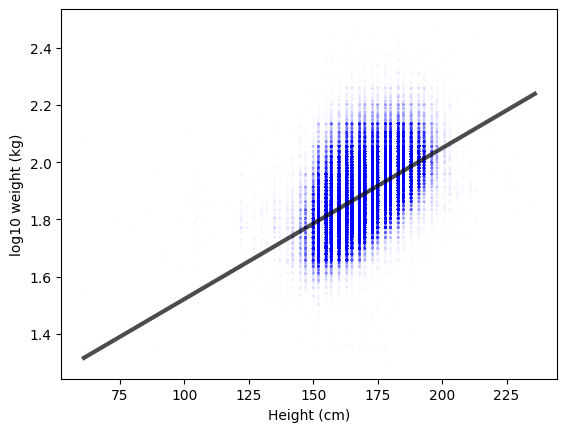

In [142]:
# Scatterplot of heights and weights on log scale
thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='black')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

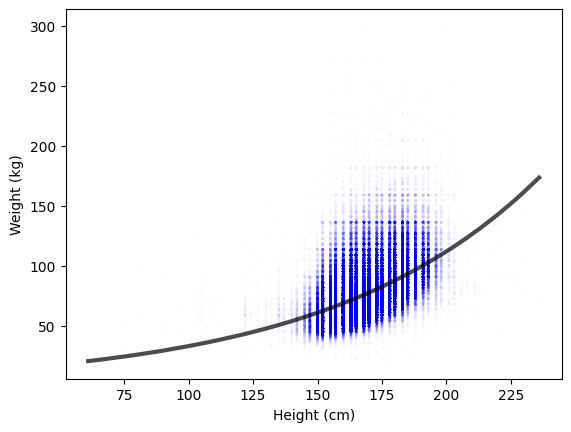

In [143]:
# Scatterplot with heights and weights not on log scale
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='black')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

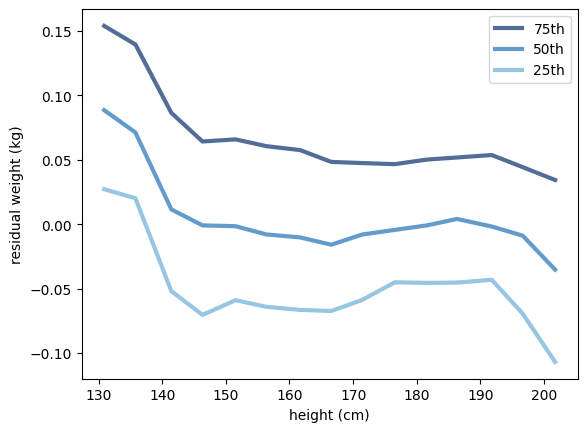

In [144]:
# Plot percentiles of the residuals
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=True)

The model works well for heights between 140 cm and 190 cm. Above and below the range, the slopes are not flat, which indicates that the residuals may not be random and that there is nonlinearity. All weight predictions for short people tend to be too high, and all predictions for taller people tend to be low. The lines are close to parallel, which indicates that the variance remains relatively constant over the range.

Between the 140 cm and 190 cm, the model allows us to use height to predict weight to within 0.1 kg.

In [145]:
# Correlation Coefficient
rho = thinkstats2.Corr(heights, log_weights)
rho
print("rho:", rho)

# Coefficient of Determination
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2
print("r2", r2)

# Check if Correlation Coefficient == Coefficient of Determination
print("r2 = rho2?", np.isclose(rho**2, r2))

rho: 0.5317282605983439
r2 0.28273494311893754
r2 = rho2? True


In [146]:
# RMSE not using heights
std_ys = thinkstats2.Std(log_weights)
print("RMSE without using height: ", std_ys)

# RMSE using heights
std_res = thinkstats2.Std(res)
print("RMSE using height: ",std_res)

print("Reduction in RMSE: %f%%" % ((1 - std_res / std_ys) * 100))

RMSE without using height:  0.10320725030004871
RMSE using height:  0.08740777080416083
Reduction in RMSE: 15.308498%


Using heights reduces the RMSE by about 15%. 

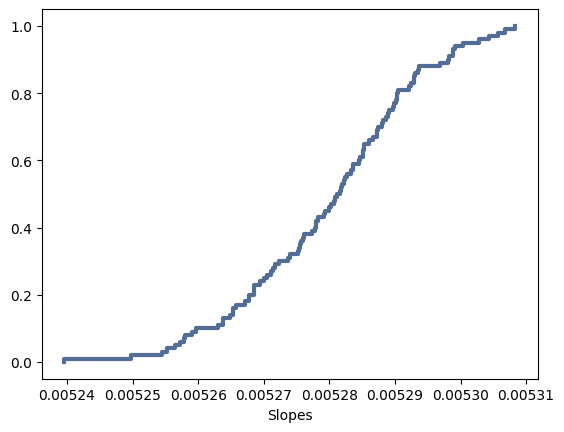

In [147]:
# Use resampling to compute sampling distributions for inter and slope
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

# Plot sampling distribution of slopes
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Slopes')


In [148]:
# P value
print("P-Value =", pvalue)

# Confidence Interval
ci5 = cdf.Percentile(5)
ci95 = cdf.Percentile(95)
print("90% Confidence Interval: ", ci5, "to", ci95)

# Mean
mean = thinkstats2.Mean(slopes)
print("Mean: ", mean)

# Standard Error
stderr = thinkstats2.Std(slopes)
print("Standard Error: ", stderr)



P-Value = 0
90% Confidence Interval:  0.0052564202569442345 to 0.0053003239837765385
Mean:  0.005279964674948656
Standard Error:  1.3563326239805753e-05


In [149]:
# From Ch10
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)


# Un-weighted Summary Statistics
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
print("Un-Weighted")
Summarize(estimates_unweighted)

# Weighted Summary Statistics
estimates_weighted = [thinkstats2.ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
print("\nWeighted")
Summarize(estimates_weighted)

Un-Weighted
mean, SE, CI 168.95776776511246 0.016408094976738844 (np.float64(168.93216566624224), np.float64(168.9849203702581))

Weighted
mean, SE, CI 170.49534368115772 0.018646884475484446 (np.float64(170.46730936356838), np.float64(170.52504597910226))


Mean height is about 1.5 cm more when taking sampled weights into account.This difference is much greater than the sampling error.